In [34]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit, minimize
import warnings
warnings.filterwarnings('ignore')

In [35]:
# data process, use participation rate model
class ParticipationRateDataProcessor:
    """Handle all data loading and preparation for participation rate GTX"""
    
    def __init__(self, base_path='.'):
        self.base_path = Path(base_path)
    
    def load_single_day(self, ticker, date_pattern):
        """Load single day data for analysis"""
        ticker_path = self.base_path / ticker
        csv_files = list(ticker_path.glob(f"{ticker}_{date_pattern}*.csv"))
        
        if not csv_files:
            return None
            
        file = csv_files[0]
        
        try:
            df = pd.read_csv(file)
            
            # Handle duplicate ts_event columns
            if list(df.columns).count('ts_event') > 1:
                cols = list(df.columns)
                first_ts_event = cols.index('ts_event')
                df = df.iloc[:, [i for i, col in enumerate(cols) if col != 'ts_event' or i == first_ts_event]]
            
            # Parse timestamps
            df['ts_event'] = pd.to_datetime(df['ts_event'], format='mixed', utc=True)
            return df
            
        except Exception:
            return None
    
    def calculate_order_book_metrics(self, df):
        """Calculate core order book metrics for participation rate model"""
        # Basic price metrics
        df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
        df['spread'] = df['ask_px_00'] - df['bid_px_00']
        df['spread_bps'] = np.where(df['mid_price'] > 0, 
                                   (df['spread'] / df['mid_price']) * 10000, 
                                   np.nan)
        
        # Depth metrics - key for participation rate
        bid_cols = [f'bid_sz_{i:02d}' for i in range(10) if f'bid_sz_{i:02d}' in df.columns]
        ask_cols = [f'ask_sz_{i:02d}' for i in range(10) if f'ask_sz_{i:02d}' in df.columns]
        
        df['total_bid_depth'] = df[bid_cols].sum(axis=1)
        df['total_ask_depth'] = df[ask_cols].sum(axis=1)
        df['total_depth'] = df['total_bid_depth'] + df['total_ask_depth']
        
        return df
    
    def create_minute_snapshots(self, df):
        """Create minute-by-minute snapshots for full day analysis"""
        # Group by minute and take last snapshot of each minute
        df['minute'] = df['ts_event'].dt.floor('T')
        minute_snapshots = df.groupby('minute').last().reset_index()
        
        # Add minute index (0 to 389 for 390 minutes of trading)
        minute_snapshots['minute_idx'] = range(len(minute_snapshots))
        
        return minute_snapshots
    
    def calculate_participation_rate_slippage(self, snapshot, max_shares=3000):
        """Calculate buy-side slippage using participation rate model"""
        # Get ask-side order book levels (where buyers execute)
        ask_price_cols = [f'ask_px_{i:02d}' for i in range(10)]
        ask_size_cols = [f'ask_sz_{i:02d}' for i in range(10)]
        
        mid_price = snapshot['mid_price']
        total_ask_volume = snapshot['total_ask_depth']
        
        # Build order book levels
        levels = []
        for i in range(10):
            if ask_price_cols[i] in snapshot.index and ask_size_cols[i] in snapshot.index:
                price = snapshot[ask_price_cols[i]]
                size = snapshot[ask_size_cols[i]]
                
                if pd.notna(price) and pd.notna(size) and size > 0:
                    levels.append({'price': price, 'size': int(size)})
        
        if not levels or total_ask_volume <= 0:
            return None
        
        total_liquidity = sum(level['size'] for level in levels)
        max_shares = min(total_liquidity, max_shares)
        
        # Calculate slippage for each trade size
        trade_sizes = []
        slippages_dollars = []
        participation_rates = []
        
        for trade_size in range(1, max_shares + 1):
            shares_remaining = trade_size
            total_cost = 0
            shares_filled = 0
            
            # Walk through order book levels
            for level in levels:
                if shares_remaining <= 0:
                    break
                    
                shares_from_level = min(shares_remaining, level['size'])
                total_cost += shares_from_level * level['price']
                shares_filled += shares_from_level
                shares_remaining -= shares_from_level
            
            # If we couldn't fill the entire order
            if shares_remaining > 0:
                break
                
            # Calculate slippage and participation rate
            avg_execution_price = total_cost / shares_filled
            slippage_dollars = avg_execution_price - mid_price
            participation_rate = trade_size / total_ask_volume
            
            trade_sizes.append(trade_size)
            slippages_dollars.append(slippage_dollars)
            participation_rates.append(participation_rate)
        
        return {
            'trade_sizes': np.array(trade_sizes),
            'slippage_dollars': np.array(slippages_dollars),
            'participation_rates': np.array(participation_rates),
            'total_ask_volume': total_ask_volume,
            'mid_price': mid_price,
            'snapshot': snapshot
        }
    
    def prepare_full_day_data(self, ticker, date_pattern):
        """Complete data preparation pipeline for full trading day"""
        # Load and prepare data
        df = self.load_single_day(ticker, date_pattern)
        if df is None:
            return None
        
        df = self.calculate_order_book_metrics(df)
        minute_snapshots = self.create_minute_snapshots(df)
        
        # Calculate slippage functions for each minute
        minute_slippage_data = {}
        
        for idx, snapshot in minute_snapshots.iterrows():
            minute_idx = snapshot['minute_idx']
            slippage_result = self.calculate_participation_rate_slippage(snapshot)
            
            if slippage_result and len(slippage_result['trade_sizes']) > 50:
                minute_slippage_data[minute_idx] = slippage_result
        
        return {
            'ticker': ticker,
            'date': date_pattern,
            'minute_snapshots': minute_snapshots,
            'minute_slippage_data': minute_slippage_data,
            'raw_data': df
        }

def fit_participation_rate_model(trade_sizes, slippage_dollars, total_volume):
    """Fit Participation Rate Model: gt(x) = α × (x/V)^β"""
    
    def model_func(x, alpha, beta):
        participation_rate = x / total_volume
        return alpha * (participation_rate ** beta)
    
    try:
        # Fit the model
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.01, 0.5], bounds=([1e-6, 0.1], [1.0, 1.5]))
        
        # Calculate performance metrics
        predictions = model_func(trade_sizes, *popt)
        ss_res = np.sum((slippage_dollars - predictions) ** 2)
        ss_tot = np.sum((slippage_dollars - np.mean(slippage_dollars)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else float('-inf')
        rmse = np.sqrt(np.mean((slippage_dollars - predictions)**2))
        
        return {
            'alpha': popt[0],
            'beta': popt[1],
            'volume': total_volume,
            'r2': r2,
            'rmse': rmse,
            'predictions': predictions,
            'equation': f'gt(x) = {popt[0]:.2e} × (x/V)^{popt[1]:.3f}'
        }
    except:
        return None

class ParticipationRateGTX:
    """GTX function based on participation rate model"""
    
    def __init__(self, alpha, beta, volume):
        self.alpha = alpha
        self.beta = beta
        self.volume = volume
    
    def calculate_cost(self, trade_size):
        """Calculate temporary impact cost for given trade size"""
        if trade_size <= 0 or self.volume <= 0:
            return 0
        
        participation_rate = trade_size / self.volume
        return self.alpha * (participation_rate ** self.beta)
    
    def calculate_total_cost(self, allocation_vector, volume_vector):
        """Calculate total cost for allocation across multiple periods"""
        total_cost = 0
        for i, (trade_size, volume) in enumerate(zip(allocation_vector, volume_vector)):
            if volume > 0 and trade_size > 0:
                participation_rate = trade_size / volume
                cost = self.alpha * (participation_rate ** self.beta)
                total_cost += cost
        return total_cost

In [36]:
# math set up
import numpy as np
from scipy.optimize import minimize, differential_evolution
from scipy.linalg import inv
import cvxpy as cp

class OptimalExecutionFramework:
    """
    Mathematical Framework for Optimal Trade Execution
    
    Problem Formulation:
    - Decision Variable: x ∈ R^N (allocation vector)
    - Constraint: sum(x_i) = S (must buy exactly S shares)
    - Constraint: x_i >= 0 (cannot sell, only buy)
    - Objective: minimize sum_{i=1}^N gt_i(x_i)
    - Where: gt_i(x) = α_i × (x/V_i)^β_i (empirical participation rate model)
    """
    
    def __init__(self, total_shares, volume_vector, alpha_vector, beta_vector, price_vector=None):
        """
        Initialize the optimization framework
        
        Parameters:
        - total_shares (S): Total shares to allocate
        - volume_vector (V): Available volume at each time period
        - alpha_vector: α parameters for each time period
        - beta_vector: β parameters for each time period
        - price_vector: Mid prices at each time period (for risk calculations)
        """
        self.S = total_shares
        self.V = np.array(volume_vector)
        self.alpha = np.array(alpha_vector)
        self.beta = np.array(beta_vector)
        self.N = len(volume_vector)
        
        # Price vector for risk calculations (use normalized if not provided)
        if price_vector is not None:
            self.prices = np.array(price_vector)
        else:
            self.prices = np.ones(self.N)  # Normalized prices
        
        # Validate inputs
        assert len(self.alpha) == self.N, "Alpha vector length mismatch"
        assert len(self.beta) == self.N, "Beta vector length mismatch"
        assert len(self.prices) == self.N, "Price vector length mismatch"
        assert all(v > 0 for v in self.V), "All volumes must be positive"
        assert self.S > 0, "Total shares must be positive"
    
    def participation_rate_cost(self, x_i, V_i, alpha_i, beta_i):
        """Calculate participation rate cost: gt(x) = α × (x/V)^β"""
        if x_i <= 0 or V_i <= 0:
            return 0
        participation_rate = x_i / V_i
        return alpha_i * (participation_rate ** beta_i)
    
    def total_cost_function(self, x):
        """Calculate total temporary impact cost across all periods"""
        total_cost = 0
        for i in range(self.N):
            if x[i] > 0:
                cost = self.participation_rate_cost(x[i], self.V[i], self.alpha[i], self.beta[i])
                total_cost += cost
        return total_cost
    
    def constraint_function(self, x):
        """Constraint: sum(x_i) - S = 0"""
        return np.sum(x) - self.S
    
    def calculate_execution_variance(self, x):
        """Calculate variance of execution for risk penalty (simplified model)"""
        # Simplified variance model based on allocation concentration
        variance = 0
        for i in range(self.N):
            if x[i] > 0 and self.V[i] > 0:
                # Higher participation rate = higher variance
                participation_rate = x[i] / self.V[i]
                # Variance increases with square of participation rate and price volatility
                period_variance = (participation_rate ** 2) * (self.prices[i] ** 2) * x[i]
                variance += period_variance
        return variance

In [37]:
# approach 1: liquidity adaptive vwap
class LiquidityAdaptiveVWAP:
    """
    Approach 1: Liquidity-Adaptive VWAP
    Strategy: Allocate based on volume availability and market conditions
    Adapts allocation to both liquidity (volume) and cost efficiency (alpha)
    """
    
    def __init__(self, framework, volume_weight=0.7, efficiency_weight=0.3):
        self.framework = framework
        self.volume_weight = volume_weight      # Weight for volume-based allocation
        self.efficiency_weight = efficiency_weight  # Weight for cost efficiency
        self.name = "Liquidity-Adaptive VWAP"
        
        # Normalize weights
        total_weight = volume_weight + efficiency_weight
        if total_weight > 0:
            self.volume_weight /= total_weight
            self.efficiency_weight /= total_weight
    
    def solve(self):
        """Solve using liquidity-adaptive VWAP strategy"""
        
        # Calculate volume weights (higher volume = more allocation)
        volume_scores = self.framework.V / np.sum(self.framework.V)
        
        # Calculate efficiency scores (lower alpha = more efficient = more allocation)
        efficiency_scores = 1.0 / (self.framework.alpha + 1e-8)
        efficiency_weights = efficiency_scores / np.sum(efficiency_scores)
        
        # Combined adaptive weights
        adaptive_weights = (self.volume_weight * volume_scores + 
                          self.efficiency_weight * efficiency_weights)
        
        # Normalize to ensure sum = 1
        adaptive_weights = adaptive_weights / np.sum(adaptive_weights)
        
        # Allocate shares based on adaptive weights
        allocation = self.framework.S * adaptive_weights
        
        # Calculate costs
        pure_cost = self.framework.total_cost_function(allocation)
        
        # Calculate theoretical uniform cost for comparison
        uniform_allocation = np.full(self.framework.N, self.framework.S / self.framework.N)
        uniform_cost = self.framework.total_cost_function(uniform_allocation)
        
        # Calculate improvement over uniform
        improvement = ((uniform_cost - pure_cost) / uniform_cost * 100) if uniform_cost > 0 else 0
        
        return {
            'allocation': allocation,
            'pure_cost': pure_cost,
            'total_objective': pure_cost,
            'algorithm': self.name,
            'description': f'Adaptive VWAP (vol:{self.volume_weight:.1f}, eff:{self.efficiency_weight:.1f})',
            'volume_weight': self.volume_weight,
            'efficiency_weight': self.efficiency_weight,
            'improvement_over_uniform': improvement
        }

In [38]:
# approach 2: mpc
class AdaptiveMPCApproach:
    """
    Approach 2: Adaptive/Dynamic Model Predictive Control
    Strategy: Reoptimizes every N periods based on remaining shares
    Adapts to changing market conditions with rolling horizon
    """
    
    def __init__(self, framework, reoptimization_frequency=30, horizon_length=60):
        self.framework = framework
        self.reopt_freq = reoptimization_frequency  # Reoptimize every N periods
        self.horizon = horizon_length  # Look-ahead horizon
        self.name = "Adaptive MPC"
    
    def solve(self):
        """Solve using Model Predictive Control with rolling horizon"""
        
        N = self.framework.N
        total_allocation = np.zeros(N)
        remaining_shares = self.framework.S
        execution_log = []
        
        # MPC loop: reoptimize periodically
        current_period = 0
        
        while current_period < N and remaining_shares > 1:
            # Define current horizon
            horizon_end = min(current_period + self.horizon, N)
            horizon_periods = horizon_end - current_period
            
            if horizon_periods <= 0:
                break
            
            # Extract horizon data
            horizon_volumes = self.framework.V[current_period:horizon_end]
            horizon_alphas = self.framework.alpha[current_period:horizon_end]
            horizon_betas = self.framework.beta[current_period:horizon_end]
            horizon_prices = self.framework.prices[current_period:horizon_end]
            
            # Create sub-problem for current horizon
            horizon_framework = OptimalExecutionFramework(
                total_shares=remaining_shares,
                volume_vector=horizon_volumes,
                alpha_vector=horizon_alphas,
                beta_vector=horizon_betas,
                price_vector=horizon_prices
            )
            
            # Solve horizon sub-problem
            horizon_allocation = self._solve_horizon_subproblem(horizon_framework)
            
            # Execute allocation for next reoptimization_frequency periods
            execution_periods = min(self.reopt_freq, horizon_periods, N - current_period)
            
            for i in range(execution_periods):
                period_idx = current_period + i
                if period_idx < N and i < len(horizon_allocation):
                    allocated_shares = horizon_allocation[i]
                    total_allocation[period_idx] = allocated_shares
                    remaining_shares -= allocated_shares
                    
                    execution_log.append({
                        'period': period_idx,
                        'allocated': allocated_shares,
                        'remaining': remaining_shares,
                        'reoptimization_cycle': len(execution_log) // self.reopt_freq
                    })
            
            # Move to next reoptimization point
            current_period += execution_periods
        
        # Distribute any remaining shares in final periods (safety measure)
        if remaining_shares > 1 and current_period < N:
            remaining_periods = N - current_period
            shares_per_period = remaining_shares / remaining_periods
            for i in range(remaining_periods):
                total_allocation[current_period + i] += shares_per_period
        
        # Calculate final metrics
        pure_cost = self.framework.total_cost_function(total_allocation)
        
        return {
            'allocation': total_allocation,
            'pure_cost': pure_cost,
            'total_objective': pure_cost,  # MPC minimizes pure cost
            'algorithm': self.name,
            'description': f'MPC (reopt every {self.reopt_freq}, horizon {self.horizon})',
            'execution_log': execution_log,
            'reoptimization_frequency': self.reopt_freq,
            'horizon_length': self.horizon,
            'num_reoptimizations': len(execution_log) // self.reopt_freq + 1
        }
    
    def _solve_horizon_subproblem(self, horizon_framework):
        """Solve sub-problem for current horizon"""
        # Simple greedy allocation for horizon (can be made more sophisticated)
        
        # Strategy: allocate proportional to (volume/cost_efficiency)
        allocation = np.zeros(horizon_framework.N)
        remaining = horizon_framework.S
        
        # Calculate efficiency scores (higher volume, lower alpha = more efficient)
        efficiency_scores = horizon_framework.V / (horizon_framework.alpha + 1e-8)
        total_efficiency = np.sum(efficiency_scores)
        
        if total_efficiency > 0:
            # Allocate proportional to efficiency
            for i in range(horizon_framework.N):
                weight = efficiency_scores[i] / total_efficiency
                allocation[i] = remaining * weight
        else:
            # Fallback to uniform
            allocation = np.full(horizon_framework.N, remaining / horizon_framework.N)
        
        return allocation

In [39]:
# approach 3: enhanced twap with liquidity and impact weighting
class EnhancedTWAPApproach:
    """
    Approach 3: Enhanced TWAP using participation rate models
    Strategy: Smart TWAP with liquidity-weighted and impact-weighted allocation
    Compares against naive TWAP to show improvement
    """
    
    def __init__(self, framework, liquidity_weight=0.5, impact_weight=0.5):
        self.framework = framework
        self.liquidity_weight = liquidity_weight  # Weight for volume-based allocation
        self.impact_weight = impact_weight        # Weight for impact-based allocation
        self.name = "Enhanced Smart TWAP"
        
        # Normalize weights
        total_weight = liquidity_weight + impact_weight
        if total_weight > 0:
            self.liquidity_weight /= total_weight
            self.impact_weight /= total_weight
    
    def solve(self):
        """Solve using Enhanced TWAP with multiple weighting schemes"""
        
        # Calculate different allocation strategies
        naive_twap = self._calculate_naive_twap()
        liquidity_weighted = self._calculate_liquidity_weighted()
        impact_weighted = self._calculate_impact_weighted()
        combined_smart = self._calculate_combined_smart()
        
        # Evaluate costs for all strategies
        strategies = {
            'Naive TWAP': naive_twap,
            'Liquidity-Weighted': liquidity_weighted,
            'Impact-Weighted': impact_weighted,
            'Combined Smart': combined_smart
        }
        
        results = {}
        for name, allocation in strategies.items():
            cost = self.framework.total_cost_function(allocation)
            results[name] = {'allocation': allocation, 'cost': cost}
        
        # Select best strategy (lowest cost)
        best_strategy = min(results.keys(), key=lambda x: results[x]['cost'])
        best_allocation = results[best_strategy]['allocation']
        best_cost = results[best_strategy]['cost']
        
        # Calculate improvement over naive TWAP
        naive_cost = results['Naive TWAP']['cost']
        improvement = ((naive_cost - best_cost) / naive_cost * 100) if naive_cost > 0 else 0
        
        return {
            'allocation': best_allocation,
            'pure_cost': best_cost,
            'total_objective': best_cost,
            'algorithm': self.name,
            'description': f'Smart TWAP ({best_strategy})',
            'best_strategy': best_strategy,
            'all_strategies': results,
            'improvement_over_naive': improvement,
            'liquidity_weight': self.liquidity_weight,
            'impact_weight': self.impact_weight
        }
    
    def _calculate_naive_twap(self):
        """Naive TWAP: equal allocation across all periods"""
        return np.full(self.framework.N, self.framework.S / self.framework.N)
    
    def _calculate_liquidity_weighted(self):
        """Liquidity-weighted: more shares when volume is higher"""
        volume_weights = self.framework.V / np.sum(self.framework.V)
        return self.framework.S * volume_weights
    
    def _calculate_impact_weighted(self):
        """Impact-weighted: more shares when impact is lower"""
        # Lower alpha = lower impact = higher weight
        impact_scores = 1.0 / (self.framework.alpha + 1e-8)
        impact_weights = impact_scores / np.sum(impact_scores)
        return self.framework.S * impact_weights
    
    def _calculate_combined_smart(self):
        """Combined: weighted combination of liquidity and impact factors"""
        # Liquidity component
        volume_weights = self.framework.V / np.sum(self.framework.V)
        
        # Impact component (inverse of alpha)
        impact_scores = 1.0 / (self.framework.alpha + 1e-8)
        impact_weights = impact_scores / np.sum(impact_scores)
        
        # Combined weights
        combined_weights = (self.liquidity_weight * volume_weights + 
                          self.impact_weight * impact_weights)
        
        # Normalize
        combined_weights = combined_weights / np.sum(combined_weights)
        
        return self.framework.S * combined_weights

In [40]:
# algo comparison
class ExecutionComparison:
    """Compare all three execution approaches"""
    
    def __init__(self, framework):
        self.framework = framework
        self.approaches = [
            LiquidityAdaptiveVWAP(framework, volume_weight=0.7, efficiency_weight=0.3),
            AdaptiveMPCApproach(framework, reoptimization_frequency=30, horizon_length=60),
            EnhancedTWAPApproach(framework, liquidity_weight=0.6, impact_weight=0.4)
        ]
    
    def run_all_approaches(self):
        """Run all execution approaches and compare results"""
        results = []
        
        for approach in self.approaches:
            result = approach.solve()
            # Ensure all results have required fields for comparison
            if 'total_objective' not in result:
                result['total_objective'] = result.get('pure_cost', float('inf'))
            results.append(result)
        
        return self.create_comparison_report(results)
    
    def create_comparison_report(self, results):
        """Create comprehensive comparison report"""
        # Sort results by total cost/objective (best to worst)
        sorted_results = sorted(results, key=lambda x: x.get('pure_cost', x.get('total_objective', float('inf'))))
        
        # Calculate cost savings relative to worst performer
        costs = [r.get('pure_cost', r.get('total_objective', 0)) for r in results]
        worst_cost = max(costs) if costs else 0
        
        for result in sorted_results:
            result_cost = result.get('pure_cost', result.get('total_objective', 0))
            cost_savings = worst_cost - result_cost
            cost_reduction_pct = (cost_savings / worst_cost) * 100 if worst_cost > 0 else 0
            result['cost_savings'] = cost_savings
            result['cost_reduction_pct'] = cost_reduction_pct
        
        return {
            'framework_summary': {
                'total_shares': self.framework.S,
                'num_periods': self.framework.N,
                'total_volume': np.sum(self.framework.V),
                'avg_alpha': np.mean(self.framework.alpha),
                'avg_beta': np.mean(self.framework.beta)
            },
            'results': sorted_results,
            'best_approach': sorted_results[0]['algorithm'],
            'best_cost': sorted_results[0].get('pure_cost', sorted_results[0].get('total_objective', 0)),
            'worst_cost': worst_cost,
            'max_savings': sorted_results[0]['cost_savings']
        }

In [41]:

def create_framework_from_slippage_data(minute_slippage_data, total_shares_to_buy=10000):
    """
    Create execution framework from fitted slippage data
    
    Parameters:
    - minute_slippage_data: Dictionary with minute-by-minute slippage functions
    - total_shares_to_buy: Total shares that need to be allocated
    """
    
    # Extract parameters from fitted models
    volumes = []
    alphas = []
    betas = []
    prices = []
    valid_minutes = []
    
    for minute_idx in sorted(minute_slippage_data.keys()):
        data = minute_slippage_data[minute_idx]
        
        # Fit participation rate model for this minute
        trade_sizes = data['trade_sizes']
        slippage_dollars = data['slippage_dollars']
        total_volume = data['total_ask_volume']
        mid_price = data['mid_price']
        
        model_result = fit_participation_rate_model(trade_sizes, slippage_dollars, total_volume)
        
        if model_result and model_result['r2'] > 0.5:  # Only use good fits
            volumes.append(total_volume)
            alphas.append(model_result['alpha'])
            betas.append(model_result['beta'])
            prices.append(mid_price)
            valid_minutes.append(minute_idx)
    
    if len(volumes) < 10:  # Need minimum number of periods
        return None, None
    
    # Create execution framework
    framework = OptimalExecutionFramework(
        total_shares=total_shares_to_buy,
        volume_vector=volumes,
        alpha_vector=alphas,
        beta_vector=betas,
        price_vector=prices
    )
    
    return framework, valid_minutes

def print_execution_comparison_results(comparison_result):
    """Print formatted execution comparison results"""
    summary = comparison_result['framework_summary']
    print(f"   Total Shares to Execute: {summary['total_shares']:,}")
    print(f"   Number of Time Periods: {summary['num_periods']}")
    print(f"   Total Available Volume: {summary['total_volume']:,.0f}")
    print(f"   Average α: {summary['avg_alpha']:.2e}")
    print(f"   Average β: {summary['avg_beta']:.3f}")
    
    # Results

    for i, result in enumerate(comparison_result['results']):
        rank = i + 1
        algorithm = result['algorithm']
        cost = result.get('pure_cost', result.get('total_objective', 0))
        savings = result['cost_savings']
        reduction_pct = result['cost_reduction_pct']
        
        print(f"\n   {rank}. {algorithm}")
        print(f"      Total Cost: ${cost:.6f}")
        print(f"      Cost Savings: ${savings:.6f}")
        print(f"      Cost Reduction: {reduction_pct:.2f}%")
        print(f"      Description: {result['description']}")
        
        # Print approach-specific details
        if 'risk_aversion' in result:
            print(f"      Risk Aversion (λ): {result['risk_aversion']}")
            print(f"      Risk Penalty: ${result.get('risk_penalty', 0):.6f}")
        elif 'num_reoptimizations' in result:
            print(f"      Reoptimizations: {result['num_reoptimizations']}")
            print(f"      Horizon Length: {result['horizon_length']}")
        elif 'improvement_over_naive' in result:
            print(f"      Improvement over Naive TWAP: {result['improvement_over_naive']:.2f}%")
            print(f"      Best Strategy: {result.get('best_strategy', 'N/A')}")
    
    # Winner
    best = comparison_result['results'][0]


In [42]:
# main analysis
def analyze_ticker_execution_strategies(ticker, date_pattern, total_shares=10000, base_path='.', verbose=False):
    """
    Complete analysis of execution strategies for a single ticker
    """
    
    if verbose:
        print(f"Analyzing {ticker} on {date_pattern}")
    
    # Step 1: Data Processing
    processor = ParticipationRateDataProcessor(base_path)
    data_result = processor.prepare_full_day_data(ticker, date_pattern)
    
    if not data_result:
        if verbose:
            print(f"Failed to load data for {ticker} on {date_pattern}")
        return None
    
    minute_slippage_data = data_result['minute_slippage_data']
    
    # Step 2: GTX Model Fitting
    fitted_models = {}
    good_fits = 0
    
    for minute_idx, slippage_data in minute_slippage_data.items():
        trade_sizes = slippage_data['trade_sizes']
        slippage_dollars = slippage_data['slippage_dollars']
        total_volume = slippage_data['total_ask_volume']
        
        model_result = fit_participation_rate_model(trade_sizes, slippage_dollars, total_volume)
        
        if model_result and model_result['r2'] > 0.5:
            fitted_models[minute_idx] = model_result
            good_fits += 1
    
    if good_fits < 10:
        if verbose:
            print(f"Insufficient good model fits ({good_fits} < 10) for {ticker}")
        return None
    
    # Step 3: Create Execution Framework
    framework, valid_minutes = create_framework_from_slippage_data(minute_slippage_data, total_shares)
    
    if not framework:
        if verbose:
            print(f"Failed to create execution framework for {ticker}")
        return None
    
    # Step 4: Run All Execution Approaches
    comparison_engine = ExecutionComparison(framework)
    comparison_result = comparison_engine.run_all_approaches()
    
    return {
        'ticker': ticker,
        'date': date_pattern,
        'total_shares': total_shares,
        'data_result': data_result,
        'fitted_models': fitted_models,
        'execution_framework': framework,
        'valid_minutes': valid_minutes,
        'comparison_result': comparison_result,
        'summary': {
            'best_approach': comparison_result['best_approach'],
            'best_cost': comparison_result['best_cost'],
            'max_cost_reduction': comparison_result['results'][0]['cost_reduction_pct'],
            'num_periods': framework.N,
            'avg_model_quality': np.mean([m['r2'] for m in fitted_models.values()])
        }
    }
    
    # Return comprehensive results
    return {
        'ticker': ticker,
        'date': date_pattern,
        'total_shares': total_shares,
        'data_result': data_result,
        'fitted_models': fitted_models,
        'execution_framework': framework,
        'valid_minutes': valid_minutes,
        'comparison_result': comparison_result,
        'summary': {
            'best_approach': comparison_result['best_approach'],
            'best_cost': comparison_result['best_cost'],
            'max_cost_reduction': comparison_result['results'][0]['cost_reduction_pct'],
            'num_periods': framework.N,
            'avg_model_quality': np.mean([m['r2'] for m in fitted_models.values()])
        }
    }

# 3 tickers
def compare_execution_strategies_across_tickers(ticker_configs, total_shares=10000, base_path='.'):
    """
    Compare execution strategies across multiple tickers
    
    Parameters:
    - ticker_configs: List of (ticker, date_pattern) tuples
    - total_shares: Number of shares to execute for each ticker
    - base_path: Path to data files
    """

    print(f"MULTI-TICKER EXECUTION STRATEGY COMPARISON")
    print(f"{'='*100}")
    print(f"Testing 3 execution approaches across {len(ticker_configs)} tickers")
    print(f"Target execution: {total_shares:,} shares per ticker")
    print(f"Approaches: Almgren-Chriss, Adaptive MPC, Enhanced TWAP")
    
    all_results = {}
    summary_data = []
    
    # Analyze each ticker
    for ticker, date_pattern in ticker_configs:
        print(f"\n{'-'*60}")
        result = analyze_ticker_execution_strategies(ticker, date_pattern, total_shares, base_path)
        
        if result:
            all_results[ticker] = result
            
            # Add to summary
            summary_data.append({
                'Ticker': ticker,
                'Date': date_pattern,
                'Best_Approach': result['summary']['best_approach'],
                'Best_Cost': result['summary']['best_cost'],
                'Cost_Reduction_Pct': result['summary']['max_cost_reduction'],
                'Num_Periods': result['summary']['num_periods'],
                'Avg_Model_R2': result['summary']['avg_model_quality']
            })
        else:
            print(f" Failed to analyze {ticker}")
    
    # Create summary DataFrame
    if summary_data:
        summary_df = pd.DataFrame(summary_data)

        
        # Overall statistics
        print(f"   Successful analyses: {len(summary_data)}/{len(ticker_configs)}")
        print(f"   Average cost reduction: {summary_df['Cost_Reduction_Pct'].mean():.2f}%")
        print(f"   Best single performance: {summary_df['Cost_Reduction_Pct'].max():.2f}% ({summary_df.loc[summary_df['Cost_Reduction_Pct'].idxmax(), 'Ticker']})")
        print(f"   Average model quality (R²): {summary_df['Avg_Model_R2'].mean():.3f}")
        
        # Approach frequency
        approach_counts = summary_df['Best_Approach'].value_counts()

        for approach, count in approach_counts.items():
            percentage = (count / len(summary_data)) * 100
            print(f"   {approach}: {count}/{len(summary_data)} ({percentage:.1f}%)")
        
        # Detailed table

        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(summary_df.round(4))
        
        return {
            'individual_results': all_results,
            'summary_df': summary_df,
            'overall_stats': {
                'success_rate': len(summary_data) / len(ticker_configs),
                'avg_cost_reduction': summary_df['Cost_Reduction_Pct'].mean(),
                'best_performance': summary_df['Cost_Reduction_Pct'].max(),
                'avg_model_quality': summary_df['Avg_Model_R2'].mean(),
                'approach_frequencies': approach_counts.to_dict()
            }
        }
    else:
        print(f"\nNo successful analyses completed")
        return None

# visual
def plot_execution_comparison(result, save_path=None):
    """Create visualization comparing the three execution approaches"""
    
    ticker = result['ticker']
    comparison_result = result['comparison_result']
    framework = result['execution_framework']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Allocation patterns
    periods = range(framework.N)
    colors = ['blue', 'green', 'red']
    
    for i, approach_result in enumerate(comparison_result['results']):
        allocation = approach_result['allocation']
        cost = approach_result.get('pure_cost', approach_result.get('total_objective', 0))
        label = f"{approach_result['algorithm']} (Cost: ${cost:.6f})"
        ax1.plot(periods, allocation, color=colors[i], linewidth=2, label=label, alpha=0.8)
    
    ax1.set_xlabel('Time Period (Minutes)')
    ax1.set_ylabel('Shares Allocated')
    ax1.set_title(f'{ticker}: Execution Patterns by Approach')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Volume vs Allocation (for best approach)
    best_result = comparison_result['results'][0]
    best_allocation = best_result['allocation']
    
    ax2.scatter(framework.V, best_allocation, alpha=0.6, s=30)
    ax2.set_xlabel('Available Volume')
    ax2.set_ylabel('Allocated Shares')
    ax2.set_title(f'{ticker}: Volume vs Allocation ({best_result["algorithm"]})')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cost comparison
    approaches = [r['algorithm'] for r in comparison_result['results']]
    costs = [r.get('pure_cost', r.get('total_objective', 0)) for r in comparison_result['results']]
    
    bars = ax3.bar(approaches, costs, color=colors)
    ax3.set_ylabel('Total Cost ($)')
    ax3.set_title(f'{ticker}: Total Cost by Approach')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add cost values on bars
    for bar, cost in zip(bars, costs):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'${cost:.6f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Cost reduction percentages
    reductions = [r['cost_reduction_pct'] for r in comparison_result['results']]
    bars = ax4.bar(approaches, reductions, color=colors)
    ax4.set_ylabel('Cost Reduction (%)')
    ax4.set_title(f'{ticker}: Cost Reduction by Approach')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add percentage values on bars
    for bar, reduction in zip(bars, reductions):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{reduction:.2f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

# ============================================================================
# EXAMPLE USAGE FUNCTIONS
# ============================================================================

# ============================================================================
# CONFIGURATION - UPDATE THESE VARIABLES FOR YOUR DATA
# ============================================================================

# Available tickers and dates from your data files
AVAILABLE_TICKERS = ['CRWV', 'FROG', 'SOUN']
AVAILABLE_DATES = [
    '2025-04-03', '2025-04-04', '2025-04-07', '2025-04-08', '2025-04-09',
    '2025-04-10', '2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
    '2025-04-17', '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24',
    '2025-04-25', '2025-04-28', '2025-04-29', '2025-04-30', '2025-05-01',
    '2025-05-02'
]

# Default settings
DEFAULT_TOTAL_SHARES = 10000
DEFAULT_BASE_PATH = '.'


In [ ]:
# example runner
def run_single_ticker_analysis(ticker=None, date=None, total_shares=None, base_path=None):
    """
    Run analysis for a single ticker
    
    Parameters:
    - ticker: Ticker symbol (default: 'CRWV')
    - date: Date in YYYY-MM-DD format (default: '2025-04-16')
    - total_shares: Total shares to execute (default: 10000)
    - base_path: Path to data files (default: '.')
    """
    
    # Set defaults
    if ticker is None:
        ticker = 'CRWV'
    if date is None:
        date = '2025-04-16'  # Using the highlighted date from your image
    if total_shares is None:
        total_shares = DEFAULT_TOTAL_SHARES
    if base_path is None:
        base_path = DEFAULT_BASE_PATH
    
    # Validate inputs
    if ticker not in AVAILABLE_TICKERS:
        print(f" Ticker '{ticker}' not available. Available tickers: {AVAILABLE_TICKERS}")
        return None
    
    if date not in AVAILABLE_DATES:
        print(f" Date '{date}' not available. Available dates: {AVAILABLE_DATES[:5]}...{AVAILABLE_DATES[-3:]}")
        return None
    
    print(f"Running single ticker analysis...")
    print(f"   Ticker: {ticker}")
    print(f"   Date: {date}")
    print(f"   Total Shares: {total_shares:,}")
    print(f"   Data Path: {base_path}")
    
    result = analyze_ticker_execution_strategies(ticker, date, total_shares, base_path)
    
    if result:
        print(f"Analysis completed successfully!")
        plot_execution_comparison(result)
        return result
    else:
        print(f"Analysis failed")
        return None

def run_comprehensive_ticker_analysis(date='2025-04-16', total_shares=10000, base_path='.'):
    """
    Run all 3 approaches on all 3 tickers and create summary DataFrame
    
    Returns:
    - detailed_results: Full results for each ticker
    - summary_df: Clean DataFrame with ticker, approach, cost_reduction, total_cost
    """
    
    tickers = ['CRWV', 'FROG', 'SOUN']
    all_results = {}
    summary_data = []
    
    print(f"Running comprehensive analysis on {date}")
    print(f"Testing 3 approaches on 3 tickers ({total_shares:,} shares each)")
    
    for ticker in tickers:
        print(f"\nAnalyzing {ticker}...")
        
        # Run analysis for this ticker
        result = analyze_ticker_execution_strategies(ticker, date, total_shares, base_path)
        
        if result:
            all_results[ticker] = result
            comparison_result = result['comparison_result']
            
            # Extract results for each approach
            for approach_result in comparison_result['results']:
                approach_name = approach_result['algorithm']
                pure_cost = approach_result.get('pure_cost', approach_result.get('total_objective', 0))
                cost_reduction = approach_result['cost_reduction_pct']
                
                summary_data.append({
                    'Ticker': ticker,
                    'Approach': approach_name,
                    'Total_Cost': pure_cost,
                    'Cost_Reduction_Pct': cost_reduction
                })
        else:
            print(f"Failed to analyze {ticker}")
    
    # Create summary DataFrame
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        # Find best approach per ticker
        best_per_ticker = summary_df.loc[summary_df.groupby('Ticker')['Cost_Reduction_Pct'].idxmax()]
        best_summary = best_per_ticker[['Ticker', 'Approach', 'Cost_Reduction_Pct', 'Total_Cost']].copy()
        best_summary.columns = ['Ticker', 'Best_Approach', 'Cost_Reduction_Pct', 'Total_Cost']
        
        return {
            'detailed_results': all_results,
            'full_summary_df': summary_df,
            'best_per_ticker_df': best_summary,
            'date': date,
            'total_shares': total_shares
        }
    else:
        return None

def run_comprehensive_analysis():
    """
    Run comprehensive analysis across all available tickers using the same date
    """
    print(f"🚀 Running comprehensive analysis...")
    print(f"   All tickers: {AVAILABLE_TICKERS}")
    print(f"   Date: 2025-04-16 (highlighted in your data)")
    print(f"   This will test all 3 execution approaches on all 3 tickers")
    
    return run_multi_ticker_analysis(
        tickers=AVAILABLE_TICKERS,
        dates='2025-04-16',
        total_shares=10000
    )

def run_custom_analysis(ticker, date, total_shares=10000):
    """
    Run custom analysis with your specified parameters
    
    Example usage:
    result = run_custom_analysis('FROG', '2025-04-23', 15000)
    """
    return run_single_ticker_analysis(ticker, date, total_shares)

def quick_start_single():
    """Quick start: Single ticker analysis"""
    print("QUICK START: Single Ticker Analysis")
    print("Using CRWV on 2025-04-16 with 10,000 shares")
    return run_single_ticker_analysis()

def quick_start_multi():
    """Quick start: Multi-ticker analysis"""

    print("Using all 3 tickers (CRWV, FROG, SOUN) on 2025-04-16")
    return run_multi_ticker_analysis()

def print_clean_results(results):
    """Print clean results - first check what columns we actually have"""
    
    if not results:
        print("No results to display")
        return
    
    print(f"Analysis Results for {results['date']}")
    print(f"Total shares per ticker: {results['total_shares']:,}")
    print("="*80)
    
    # Debug: show what columns we actually have
    full_df = results['full_summary_df']
    print("DEBUG - Full DataFrame columns:", full_df.columns.tolist())
    print("DEBUG - First few rows:")
    print(full_df.head())
    
    # Use whatever columns we have
    print("\nFull Results:")
    print(full_df.round(4).to_string(index=False))
    
    # Best per ticker table
    print(f"\nBest Approach per Ticker:")
    best_df = results['best_per_ticker_df']
    print("DEBUG - Best DataFrame columns:", best_df.columns.tolist())
    print(best_df.round(4).to_string(index=False))

def run_analysis_with_uniform_benchmark():
    """Run analysis with proper uniform allocation benchmark"""
    
    date = '2025-04-16'
    total_shares = 10000
    base_path = '.'
    tickers = ['CRWV', 'FROG', 'SOUN']
    
    print(f"Running comprehensive analysis on {date}")
    print(f"Testing 3 approaches on 3 tickers ({total_shares:,} shares each)")
    print("Using uniform allocation as benchmark")
    
    all_results = {}
    summary_data = []
    
    for ticker in tickers:
        print(f"Analyzing {ticker}...")
        
        # Run individual ticker analysis
        result = analyze_ticker_execution_strategies(ticker, date, total_shares, base_path, verbose=False)
        
        if result:
            all_results[ticker] = result
            framework = result['execution_framework']
            comparison_result = result['comparison_result']
            
            # Calculate uniform allocation benchmark
            uniform_allocation = np.full(framework.N, framework.S / framework.N)
            uniform_cost = framework.total_cost_function(uniform_allocation)
            
            print(f"  {ticker} uniform cost: ${uniform_cost:.4f}")
            
            # Process each approach result
            for approach_result in comparison_result['results']:
                approach_name = approach_result['algorithm']
                approach_cost = approach_result.get('pure_cost', approach_result.get('total_objective', 0))
                
                # Calculate cost reduction vs uniform (the RIGHT way)
                cost_reduction_vs_uniform = ((uniform_cost - approach_cost) / uniform_cost * 100) if uniform_cost > 0 else 0
                
                print(f"    {approach_name}: ${approach_cost:.4f} ({cost_reduction_vs_uniform:.2f}% vs uniform)")
                
                summary_data.append({
                    'Ticker': ticker,
                    'Approach': approach_name,
                    'Total_Cost': approach_cost,
                    'Uniform_Cost': uniform_cost,
                    'Cost_Reduction_vs_Uniform': cost_reduction_vs_uniform,
                    'Cost_Savings_Dollars': uniform_cost - approach_cost
                })
        else:
            print(f"  Failed to analyze {ticker}")
    
    if not summary_data:
        print("No successful analyses")
        return None
    
    # Create DataFrames
    full_df = pd.DataFrame(summary_data)
    
    # Best approach per ticker
    best_per_ticker = full_df.loc[full_df.groupby('Ticker')['Cost_Reduction_vs_Uniform'].idxmax()]
    best_df = best_per_ticker[['Ticker', 'Approach', 'Cost_Reduction_vs_Uniform', 'Total_Cost', 'Uniform_Cost', 'Cost_Savings_Dollars']].copy()
    best_df.columns = ['Ticker', 'Best_Approach', 'Cost_Reduction_vs_Uniform', 'Total_Cost', 'Uniform_Cost', 'Cost_Savings_Dollars']
    
    return {
        'detailed_results': all_results,
        'full_summary_df': full_df,
        'best_per_ticker_df': best_df,
        'date': date,
        'total_shares': total_shares
    }

def print_final_results(results):
    """Print clean final results with uniform benchmark"""
    
    if not results:
        print("No results to display")
        return
    
    print(f"\n" + "="*80)
    print(f"FINAL RESULTS - {results['date']}")
    print(f"Total shares per ticker: {results['total_shares']:,}")
    print(f"Benchmark: Uniform allocation (equal shares per period)")
    print("="*80)
    
    # Full results
    print(f"\nAll Approach Results:")
    full_df = results['full_summary_df']
    display_cols = ['Ticker', 'Approach', 'Total_Cost', 'Uniform_Cost', 'Cost_Reduction_vs_Uniform']
    print(full_df[display_cols].round(4).to_string(index=False))
    
    # Best per ticker
    print(f"\nBest Approach per Ticker:")
    best_df = results['best_per_ticker_df']
    display_cols = ['Ticker', 'Best_Approach', 'Cost_Reduction_vs_Uniform', 'Total_Cost', 'Cost_Savings_Dollars']
    print(best_df[display_cols].round(4).to_string(index=False))
    
    # Summary stats
    print(f"\nSummary Statistics:")
    avg_reduction = best_df['Cost_Reduction_vs_Uniform'].mean()
    max_reduction = best_df['Cost_Reduction_vs_Uniform'].max()
    total_savings = best_df['Cost_Savings_Dollars'].sum()
    best_ticker = best_df.loc[best_df['Cost_Reduction_vs_Uniform'].idxmax(), 'Ticker']
    
    print(f"  Average cost reduction vs uniform: {avg_reduction:.2f}%")
    print(f"  Best single performance: {max_reduction:.2f}% ({best_ticker})")
    print(f"  Total cost savings: ${total_savings:.4f}")
    
    # Approach winners
    approach_counts = best_df['Best_Approach'].value_counts()
    print(f"\nWinning Approach Frequency:")
    for approach, count in approach_counts.items():
        print(f"  {approach}: {count}/3 tickers ({count/3*100:.1f}%)")
    
    return results

def create_report_visualizations(results):
    """Create clean visualizations for the report - only heatmap and bar chart"""
    
    if not results:
        print("No results to visualize")
        return None
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Optimal Execution Strategy Analysis - {results["date"]}', fontsize=16, fontweight='bold')
    
    # Data preparation
    full_df = results['full_summary_df']
    
    # 1. Cost Reduction by Approach and Ticker (Heatmap)
    pivot_df = full_df.pivot(index='Ticker', columns='Approach', values='Cost_Reduction_vs_Uniform')
    
    # Shorten approach names for better display
    pivot_df.columns = ['Adaptive MPC', 'Enhanced TWAP', 'Liquidity VWAP']
    
    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                ax=ax1, cbar_kws={'label': 'Cost Reduction (%)'})
    ax1.set_title('Cost Reduction vs Uniform Allocation (%)')
    ax1.set_ylabel('Ticker')
    ax1.set_xlabel('Execution Approach')
    
    # 2. Total Cost Comparison (Bar Chart)
    cost_data = []
    tickers = full_df['Ticker'].unique()
    
    for ticker in tickers:
        ticker_data = full_df[full_df['Ticker'] == ticker]
        uniform_cost = ticker_data['Uniform_Cost'].iloc[0]
        
        # Add uniform cost
        cost_data.append({'Ticker': ticker, 'Approach': 'Uniform (Baseline)', 'Cost': uniform_cost})
        
        # Add approach costs
        for _, row in ticker_data.iterrows():
            short_name = row['Approach'].replace('Liquidity-Adaptive VWAP', 'Liquidity VWAP').replace('Enhanced Smart TWAP', 'Enhanced TWAP')
            cost_data.append({'Ticker': row['Ticker'], 'Approach': short_name, 'Cost': row['Total_Cost']})
    
    cost_df = pd.DataFrame(cost_data)
    
    # Plot grouped bar chart
    tickers = cost_df['Ticker'].unique()
    x = np.arange(len(tickers))
    width = 0.2
    
    approaches = ['Uniform (Baseline)', 'Adaptive MPC', 'Enhanced TWAP', 'Liquidity VWAP']
    colors = ['gray', '#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, approach in enumerate(approaches):
        approach_data = cost_df[cost_df['Approach'] == approach]
        costs = [approach_data[approach_data['Ticker'] == ticker]['Cost'].iloc[0] if not approach_data[approach_data['Ticker'] == ticker].empty else 0 for ticker in tickers]
        ax2.bar(x + i * width, costs, width, label=approach, color=colors[i], alpha=0.8)
    
    ax2.set_xlabel('Ticker')
    ax2.set_ylabel('Total Cost ($)')
    ax2.set_title('Total Execution Costs by Approach')
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(tickers)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_summary_dataframe(results):
    """Create a clean summary DataFrame instead of visualization"""
    
    if not results:
        print("No results to summarize")
        return None
    
    # Prepare data for summary table
    best_df = results['best_per_ticker_df']
    
    # Create clean summary DataFrame
    summary_data = []
    for _, row in best_df.iterrows():
        summary_data.append({
            'Ticker': row['Ticker'],
            'Best_Approach': row['Best_Approach'].replace('Liquidity-Adaptive VWAP', 'Liquidity VWAP').replace('Enhanced Smart TWAP', 'Enhanced TWAP'),
            'Cost_Reduction_Pct': round(row['Cost_Reduction_vs_Uniform'], 1),
            'Optimized_Cost': round(row['Total_Cost'], 4),
            'Uniform_Cost': round(row['Uniform_Cost'], 4),
            'Savings_Dollars': round(row['Cost_Savings_Dollars'], 4)
        })
    
    # Add summary row
    avg_reduction = best_df['Cost_Reduction_vs_Uniform'].mean()
    total_savings = best_df['Cost_Savings_Dollars'].sum()
    
    summary_data.append({
        'Ticker': 'AVERAGE',
        'Best_Approach': '-',
        'Cost_Reduction_Pct': round(avg_reduction, 1),
        'Optimized_Cost': '-',
        'Uniform_Cost': '-',
        'Savings_Dollars': round(total_savings, 4)
    })
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"\nSummary Results Table:")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    return summary_df

def run_analysis():
    """Run the corrected analysis with uniform benchmark and simplified visualizations"""
    results = run_analysis_with_uniform_benchmark()
    if results:
        # Print results
        print_final_results(results)
        
        # Create visualizations
        print(f"\nGenerating visualizations...")
        fig1 = create_report_visualizations(results)  # Only heatmap + bar chart
        
        # Create summary DataFrame instead of table plot
        summary_df = create_summary_dataframe(results)
        
        return {
            'results': results,
            'summary_dataframe': summary_df,
            'figure': fig1
        }
    else:
        print("Analysis failed")
        return None

Running comprehensive analysis on 2025-04-16
Testing 3 approaches on 3 tickers (10,000 shares each)
Using uniform allocation as benchmark
Analyzing CRWV...
  CRWV uniform cost: $11.5104
    Adaptive MPC: $7.3919 (35.78% vs uniform)
    Enhanced Smart TWAP: $10.6787 (7.23% vs uniform)
    Liquidity-Adaptive VWAP: $10.9865 (4.55% vs uniform)
Analyzing FROG...
  FROG uniform cost: $11.9368
    Enhanced Smart TWAP: $10.1958 (14.58% vs uniform)
    Liquidity-Adaptive VWAP: $11.2565 (5.70% vs uniform)
    Adaptive MPC: $12.5694 (-5.30% vs uniform)
Analyzing SOUN...
  SOUN uniform cost: $0.4833
    Adaptive MPC: $0.4578 (5.27% vs uniform)
    Enhanced Smart TWAP: $0.4732 (2.09% vs uniform)
    Liquidity-Adaptive VWAP: $0.4763 (1.44% vs uniform)

FINAL RESULTS - 2025-04-16
Total shares per ticker: 10,000
Benchmark: Uniform allocation (equal shares per period)

All Approach Results:
Ticker                Approach  Total_Cost  Uniform_Cost  Cost_Reduction_vs_Uniform
  CRWV            Adaptive MP

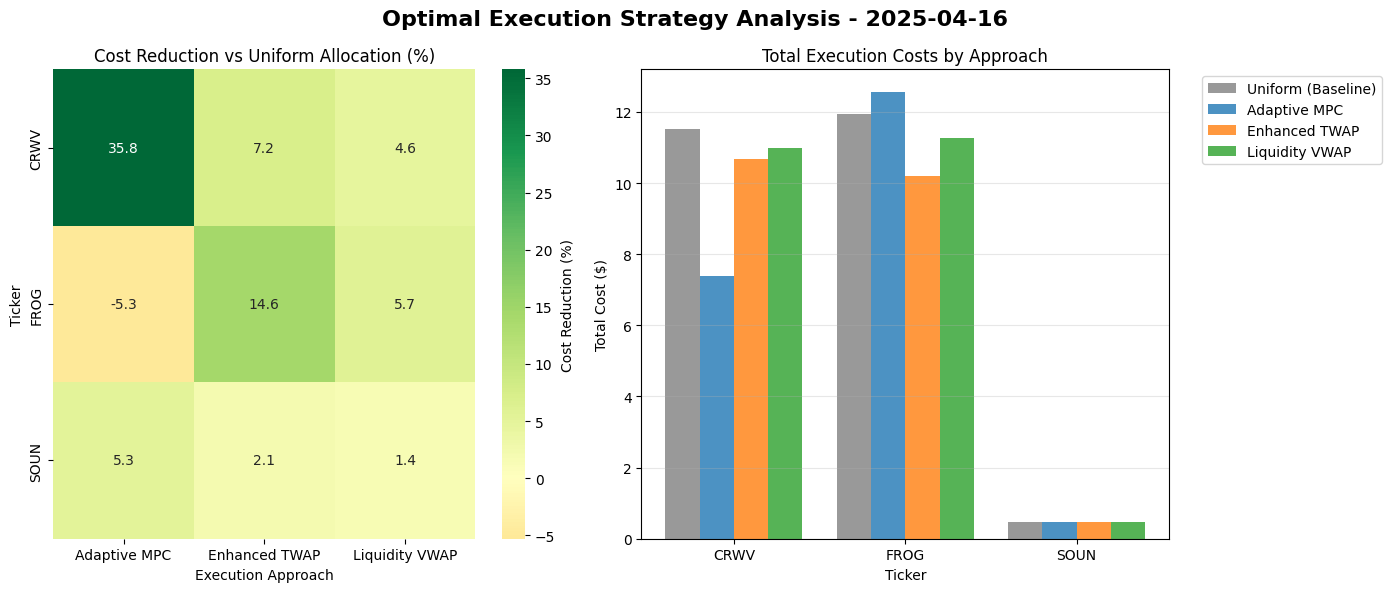


Summary Results Table:
 Ticker Best_Approach  Cost_Reduction_Pct Optimized_Cost Uniform_Cost  Savings_Dollars
   CRWV  Adaptive MPC                35.8         7.3919      11.5104           4.1185
   FROG Enhanced TWAP                14.6        10.1958      11.9368           1.7409
   SOUN  Adaptive MPC                 5.3         0.4578       0.4833           0.0255
AVERAGE             -                18.5              -            -           5.8849


In [44]:
results = run_analysis()